# Homework 4
### ASTROINFORMATICS
https://github.com/astromundus/astroinfo2018


## Problem

The flux vs. time plot below shows UV flux measurements for an active M dwarf
star. These stars are known for their exponential bursts of energy, well described
by the profile:

$$\rm{flux(time)} = A\,exp(-\alpha \, t)$$ 

for $t>T$ (recall Week-5-Thu lecture).

Find how many bursts were observed for this star during the provided 2 hour 
stretch of data and estimate their amplitudes (A), decay constants ($\alpha$),
and the time of bursts.

**Hints:**
- You can relatively easily solve this problem by generalizing the code from [fig. 10.25](http://www.astroml.org/book_figures/chapter10/fig_matchedfilt_burst.html)
- There are no more than 2 bursts in this dataset. I.e., you can fit a single-burst model, and then a double-burst model, and then compare which one fits better. Show the posteriors plots (like in [fig. 10.25](http://www.astroml.org/book_figures/chapter10/fig_matchedfilt_burst.html)) for both models.
- You can use flat priors for A and T and the background (non-bursting) flux level, and Jeffreys' prior, $p(\alpha) \propto \alpha^{-1}$, for $\alpha$
- You can do approximate model comparison based on the BIC 

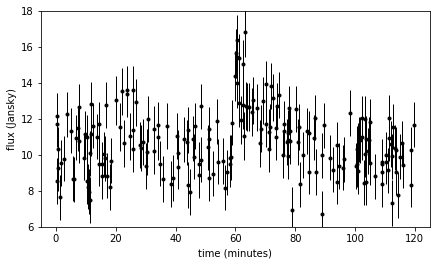

In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

# read data
data = np.loadtxt('HW4dataFinal.txt', unpack=True)
t, y_obs, sigma_y = data

# plot data
fig = plt.figure(figsize=(12, 12))
ax = fig.add_axes([0.5, 0.7, 0.45, 0.25])
ax.errorbar(t, y_obs, sigma_y, fmt='.', lw=1, c='k')
ax.set_xlim(-5, 125)
ax.set_ylim(6.0, 18.001)
ax.set_xlabel('time (minutes)')
ax.set_ylabel(r'flux (Jansky)')

plt.show()

## Solution

 [-----------------100%-----------------] 25000 of 25000 complete in 12.8 sec

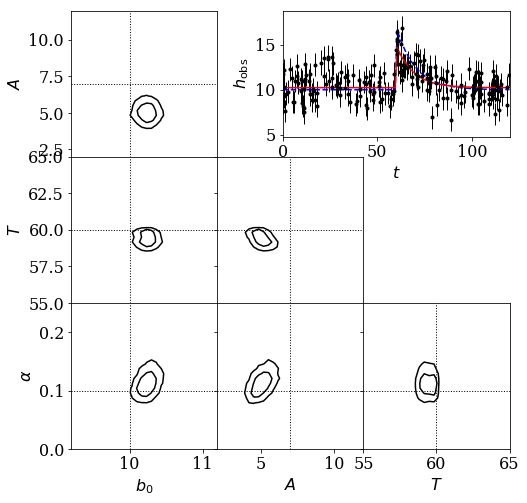

In [4]:
### AstroML book figure 10.25

# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from matplotlib import pyplot as plt

# Hack to fix import issue in older versions of pymc
import scipy
import scipy.misc
scipy.derivative = scipy.misc.derivative
import pymc

from astroML.plotting.mcmc import plot_mcmc
from astroML.decorators import pickle_results

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=16, usetex=False)


#----------------------------------------------------------------------
# Set up toy dataset
def burst(t, b0, A, alpha, T):
    """Burst model"""
    y = np.empty(t.shape)
    y.fill(b0)
    mask = (t >= T)
    y[mask] += A * np.exp(-alpha * (t[mask] - T))
    return y

np.random.seed(0)

N = 120
b0_true = 10
A_true = 7
alpha_true = 0.1
T_true = 60
sigma = 1.0


# Generate the burst data -- true burst + some background
y_true = burst(t, b0_true, A_true, alpha_true, T_true)



#----------------------------------------------------------------------
# Set up MCMC sampling
b0 = pymc.Uniform('b0', 0, 50, value=50 * np.random.random())
A = pymc.Uniform('A', 0, 50, value=50 * np.random.random())
T = pymc.Uniform('T', 0, 120, value=120 * np.random.random())
log_alpha = pymc.Uniform('log_alpha', -10, 10, value=0)


# uniform prior on log(alpha)
@pymc.deterministic
def alpha(log_alpha=log_alpha):
    return np.exp(log_alpha)


@pymc.deterministic
def y_model(t=t, b0=b0, A=A, alpha=alpha, T=T):
    return burst(t, b0, A, alpha, T)

y = pymc.Normal('y', mu=y_model, tau=sigma ** -2, observed=True, value=y_obs)

model = dict(b0=b0, A=A, T=T, log_alpha=log_alpha,
             alpha=alpha, y_model=y_model, y=y)


#----------------------------------------------------------------------
# Run the MCMC sampling

def compute_MCMC_results(niter=25000, burn=4000):
    S = pymc.MCMC(model)
    S.sample(iter=niter, burn=burn)
    traces = [S.trace(s)[:] for s in ['b0', 'A', 'T', 'alpha']]

    M = pymc.MAP(model)
    M.fit()
    fit_vals = (M.b0.value, M.A.value, M.alpha.value, M.T.value)

    return traces, fit_vals

traces, fit_vals = compute_MCMC_results()

labels = ['$b_0$', '$A$', '$T$', r'$\alpha$']
limits = [(9.2, 11.2), (2, 12), (55, 65), (0.0, 0.25)]
true = [b0_true, A_true, T_true, alpha_true]

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(7, 7))
fig.subplots_adjust(bottom=0.1, top=0.95,
                    left=0.1, right=0.95,
                    hspace=0.05, wspace=0.05)

# This function plots multiple panels with the traces
plot_mcmc(traces, labels=labels, limits=limits, true_values=true, fig=fig,
          bins=30, colors='k')

# Plot the model fit
ax = fig.add_axes([0.5, 0.7, 0.45, 0.25])
t_fit = np.linspace(0, 120, 120)
y_fit = burst(t_fit, *fit_vals)
y_true = burst(t_fit, b0_true, A_true, alpha_true, T_true)

ax.scatter(t, y_obs, s=9, lw=0, c='k')
ax.errorbar(t, y_obs, sigma_y, fmt='.', lw=1, c='k')
ax.plot(t_fit, y_true, '--', c='blue')
ax.plot(t_fit, y_fit, '-k', c='red')
ax.set_xlim(0, 120)
ax.set_xlabel('$t$')
ax.set_ylabel(r'$h_{\rm obs}$')

plt.show() 

In [7]:
k = 4
chi_square = np.sum((y_true-y_fit)**2)/((N-k)*sigma**2)
BIC = chi_square + k*np.log(N)
print(chi_square,BIC)

0.21864678258538514 19.368613753713568


 [-----------------100%-----------------] 25000 of 25000 complete in 20.4 sec

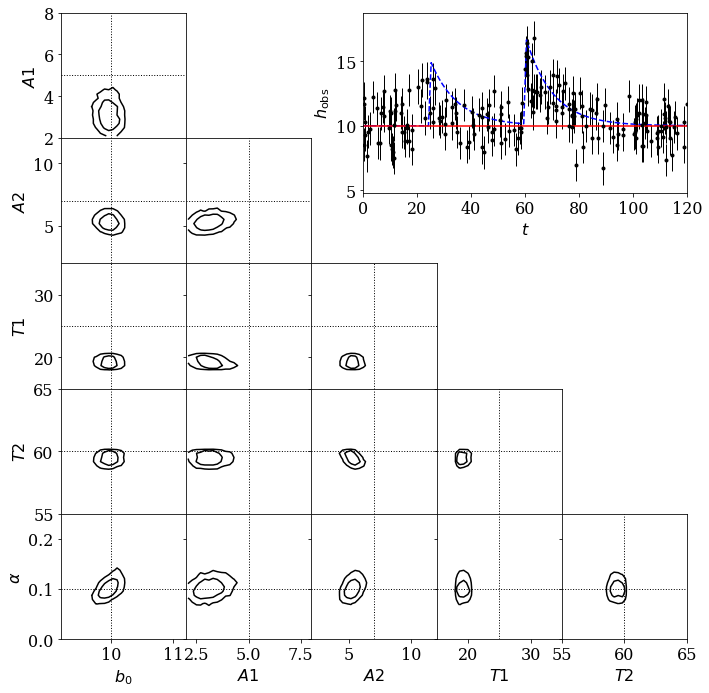

In [8]:
def burst(t, b0, A1, A2, alpha, T1, T2):
    """Burst model"""
    y = np.empty(t.shape)
    y.fill(b0)
    mask1 = ( (t >= T1) & (t < T2) )
    mask2 = (t >= T2)
    y[mask1] += A1 * np.exp(-alpha * (t[mask1] - T1))
    y[mask2] += A2 * np.exp(-alpha * (t[mask2] - T2))
    
    return y

np.random.seed(0)

N = 120
b0_true = 10
A1_true = 5
A2_true = 7
alpha_true = 0.1
T1_true = 25
T2_true = 60
sigma = 1.0

# Generate the burst data -- true burst + some background
y_true = burst(t, b0_true, A1_true, A2_true, alpha_true, T1_true, T2_true)



#----------------------------------------------------------------------
# Set up MCMC sampling
b0 = pymc.Uniform('b0', 0, 50, value=50 * np.random.random())
A1 = pymc.Uniform('A1', 0, 50, value=50 * np.random.random())
A2 = pymc.Uniform('A2', 0, 50, value=50 * np.random.random())
T1 = pymc.Uniform('T1', 0, 120, value=120 * np.random.random())
T2 = pymc.Uniform('T2', 0, 120, value=120 * np.random.random())

log_alpha = pymc.Uniform('log_alpha', -10, 10, value=0)


# uniform prior on log(alpha)
@pymc.deterministic
def alpha(log_alpha=log_alpha):
    return np.exp(log_alpha)


@pymc.deterministic
def y_model(t=t, b0=b0, A1=A1, A2=A2, alpha=alpha, T1=T1, T2=T2):
    return burst(t, b0, A1, A2, alpha, T1, T2)

y = pymc.Normal('y', mu=y_model, tau=sigma ** -2, observed=True, value=y_obs)

model = dict(b0=b0, A1=A1, A2=A2, T1=T1, T2=T2, log_alpha=log_alpha,
             alpha=alpha, y_model=y_model, y=y)


#----------------------------------------------------------------------
# Run the MCMC sampling

def compute_MCMC_results(niter=25000, burn=4000):
    S = pymc.MCMC(model)
    S.sample(iter=niter, burn=burn)
    traces = [S.trace(s)[:] for s in ['b0', 'A1', 'A2', 'T1', 'T2', 'alpha']]

    M = pymc.MAP(model)
    M.fit()
    fit_vals = (M.b0.value, M.A1.value, M.A2.value, M.T1.value, M.T2.value, M.alpha.value)

    return traces, fit_vals

traces, fit_vals = compute_MCMC_results()

labels = ['$b_0$', '$A1$','$A2$', '$T1$', '$T2$' ,r'$\alpha$']
limits = [(9.2, 11.2), (2, 8), (2, 12), (15, 35), (55, 65), (0.0, 0.25)]
true = [b0_true, A1_true, A2_true, T1_true, T2_true, alpha_true]

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(10,10))
fig.subplots_adjust(bottom=0.1, top=0.95,
                    left=0.1, right=0.95,
                    hspace=0.05, wspace=0.05)

# This function plots multiple panels with the traces
plot_mcmc(traces, labels=labels, limits=limits, true_values=true, fig=fig,
          bins=30, colors='k')

# Plot the model fit
ax = fig.add_axes([0.5, 0.7, 0.45, 0.25])
t_fit = np.linspace(0, 120, 120)
y_fit = burst(t_fit, *fit_vals)
y_true = burst(t_fit, b0_true, A1_true, A2_true, alpha_true, T1_true, T2_true)

ax.scatter(t, y_obs, s=9, lw=0, c='k')
ax.errorbar(t, y_obs, sigma_y, fmt='.', lw=1, c='k')
ax.plot(t_fit, y_true, '--', c='blue')
ax.plot(t_fit, y_fit, '-k', c='red')
ax.set_xlim(0, 120)
ax.set_xlabel('$t$')
ax.set_ylabel(r'$h_{\rm obs}$')

plt.show() 

In [14]:
k = 6
chi_square = np.sum((y_true-y_fit)**2)/((N-k)*sigma**2)
BIC = chi_square + k*np.log(N)
print(chi_square, BIC)

3.3561488739646204 32.0810993306569


From chi square and BIC method, single burst best fits the data.